In [18]:
library(ggplot2)
library(stats)
library(rhdf5)
library(MASS)

In [19]:
at.scale.results <- read.csv(
    '/iblm/netapp/data1/external/Gasperini2019/processed/23_01_12_enhancer_enhancer_at_scale_20_cells_pseudocount_model.csv'
)
at.scale.results <- at.scale.results[complete.cases(at.scale.results), ]

In [20]:
head(at.scale.results)

,enhancer.1.list,enhancer.2.list,gene.list,enhancer.1.pvalue.list,enhancer.2.pvalue.list,interaction.coeff.list,interaction.pvalue.list
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr20.2320,chr20.2372,ENSG00000000419,0.006855962,0.7608843,0.2669999,0.6674661
2,chr11.2897,chr11.3041,ENSG00000002330,0.817188400,0.2701274,0.1748857,0.7050955
3,chr11.2920,chr11.3041,ENSG00000002330,0.562828043,0.2650436,0.1775677,0.7511936
4,chr11.3041,chr11.3163,ENSG00000002330,0.283744404,0.5700953,0.3538145,0.4696702
5,chr16.1863,chr16.1866,ENSG00000004779,0.550137664,0.7950268,0.1905582,0.5165707
6,chr16.1865,chr16.1866,ENSG00000004779,0.433554202,0.9447717,-0.2687634,0.2912712


In [21]:
nrow(at.scale.results)

[1] 3808

In [22]:
# add FDR adjusted p-values and filter for FDR < 0.1
at.scale.results$adjusted.interaction.pvalue <- p.adjust(at.scale.results$interaction.pvalue.list, method = 'fdr')
significant.interactions <- at.scale.results[at.scale.results$adjusted.interaction.pvalue < 0.1, ]


In [23]:
significant.interactions

,enhancer.1.list,enhancer.2.list,gene.list,enhancer.1.pvalue.list,enhancer.2.pvalue.list,interaction.coeff.list,interaction.pvalue.list,adjusted.interaction.pvalue
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1241,chr1.12443,chr1.12449,ENSG00000116903,0.7220851,0.2475178,3.507750,1.091943e-05,1.039530e-02
2626,chr2.1137,chr2.1212,ENSG00000158019,0.4728296,0.3786960,4.577375,1.622546e-21,6.178656e-18
4261,chr6.1231,chr6.1282,ENSG00000197903,0.5195701,0.4944020,1.806754,3.716034e-06,7.075329e-03
4547,chr6.1282,chr6.1347,ENSG00000232040,0.1335886,0.6352940,2.934739,1.029357e-05,1.039530e-02


In [24]:
# filter for necessary columns in significant interactions
significant.interactions <- significant.interactions[, c('enhancer.1.list', 'enhancer.2.list', 'gene.list')]
colnames(significant.interactions) <- c('enhancer.1', 'enhancer.2', 'gene')


In [25]:
significant.interactions

,enhancer.1,enhancer.2,gene
,<chr>,<chr>,<chr>
1241,chr1.12443,chr1.12449,ENSG00000116903
2626,chr2.1137,chr2.1212,ENSG00000158019
4261,chr6.1231,chr6.1282,ENSG00000197903
4547,chr6.1282,chr6.1347,ENSG00000232040


In [26]:
# read in and sort covariates
print('reading in covariates!')
covariates <- h5read(
    file = '/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5',
    name = 'covariates'
)
cell.barcodes <- h5read(
    file = '/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5',
    name = 'cell.barcodes'
)
covariates <- merge(
    data.frame(cell.barcodes),
    covariates,
    by.x = 'cell.barcodes',
    by.y = 'cell',
    sort = FALSE
)

[1] "reading in covariates!"


In [27]:
# read in table mapping enhancers to spacers and reformat enhancer names
print('reading in enhancer-to-spacer table!')
enhancer.to.spacer.table <- read.table(
    '/iblm/netapp/data1/external/Gasperini2019/suppl/GSE120861_grna_groups.at_scale.txt',
    sep = '\t'
)
colnames(enhancer.to.spacer.table) <- c('target.site', 'spacer.sequence')
enhancer.to.spacer.table$target.site <- sapply(enhancer.to.spacer.table$target.site, FUN = function(x) {
    if (startsWith(x, 'chr')) {
        return (strsplit(x, '_')[[1]][1])
    }
    else {
        return (x)
    }
})

[1] "reading in enhancer-to-spacer table!"


In [28]:
# read in guide efficiency information
print('reading in guide efficiencies!')
guide.efficiencies.table <- h5read(
    '/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5',
    'guidescan.output'
)
guide.efficiencies.table$spacer <- substring(
    guide.efficiencies.table$gRNA,
    1,
    nchar(guide.efficiencies.table$gRNA) - 3
)

[1] "reading in guide efficiencies!"


In [29]:
# read in cell-guide matrix
print('reading in cell-guide matrix!')
cell.guide.matrix <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5', 'cell.guide.matrix')
guide.spacers <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5', 'guide.spacers')
colnames(cell.guide.matrix) <- guide.spacers

# read in counts matrix
print('reading in counts matrix!')
counts.matrix <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5', 'gene.counts')
gene.names <- h5read('/iblm/netapp/data1/external/Gasperini2019/processed/gasperini_data.h5', 'gene.names')
rownames(counts.matrix) <- gene.names

[1] "reading in cell-guide matrix!"
[1] "reading in counts matrix!"


In [30]:
# compute scaling factors based on count matrix
print('computing scaling factors!')
scaling.factors <- colSums(counts.matrix) / 1e6

[1] "computing scaling factors!"


In [49]:
# define enhancers and gene
enhancer.1 <- significant.interactions[4, 'enhancer.1']
enhancer.2 <- significant.interactions[4, 'enhancer.2']
gene <- significant.interactions[4, 'gene']

enhancer.1.spacers <- enhancer.to.spacer.table[enhancer.to.spacer.table$target.site == enhancer.1, ]$spacer.sequence
enhancer.2.spacers <- enhancer.to.spacer.table[enhancer.to.spacer.table$target.site == enhancer.2, ]$spacer.sequence

# get guide effiencies corresponding to spacers
enhancer.1.spacers.efficiencies <- guide.efficiencies.table[guide.efficiencies.table$spacer %in% enhancer.1.spacers, c('spacer', 'Cutting.Efficiency')]
enhancer.2.spacers.efficiencies <- guide.efficiencies.table[guide.efficiencies.table$spacer %in% enhancer.2.spacers, c('spacer', 'Cutting.Efficiency')]

enhancer.1.spacers.efficiencies[is.na(enhancer.1.spacers.efficiencies)] <- 0
enhancer.2.spacers.efficiencies[is.na(enhancer.2.spacers.efficiencies)] <- 0

In [50]:
enhancer.1.indicator.probs <- rep(1, nrow(cell.guide.matrix))

for (j in 1:nrow(enhancer.1.spacers.efficiencies)) {
    guide.spacer <- enhancer.1.spacers.efficiencies$spacer[j]
    guide.efficiency <- enhancer.1.spacers.efficiencies$Cutting.Efficiency[j]
    guide.indicator.vector <- cell.guide.matrix[, guide.spacer]
    guide.probs <- 1 - (guide.indicator.vector * guide.efficiency)
    enhancer.1.indicator.probs <- enhancer.1.indicator.probs * guide.probs
}

enhancer.1.indicator.probs <- 1 - enhancer.1.indicator.probs
enhancer.1.indicator.vector <- enhancer.1.indicator.probs

enhancer.2.indicator.probs <- rep(1, nrow(cell.guide.matrix))

for (j in 1:nrow(enhancer.2.spacers.efficiencies)) {
    guide.spacer <- enhancer.2.spacers.efficiencies$spacer[j]
    guide.efficiency <- enhancer.2.spacers.efficiencies$Cutting.Efficiency[j]
    guide.indicator.vector <- cell.guide.matrix[, guide.spacer]
    guide.probs <- 1 - (guide.indicator.vector * guide.efficiency)
    enhancer.2.indicator.probs <- enhancer.2.indicator.probs * guide.probs
}

enhancer.2.indicator.probs <- 1 - enhancer.2.indicator.probs
enhancer.2.indicator.vector <- enhancer.2.indicator.probs

In [51]:
# get gene counts for gene
pseudocount <- 0.01
gene.counts <- counts.matrix[gene, ] + pseudocount

In [52]:
model.df <- cbind(covariates, enhancer.1.indicator.vector, enhancer.2.indicator.vector, gene.counts)

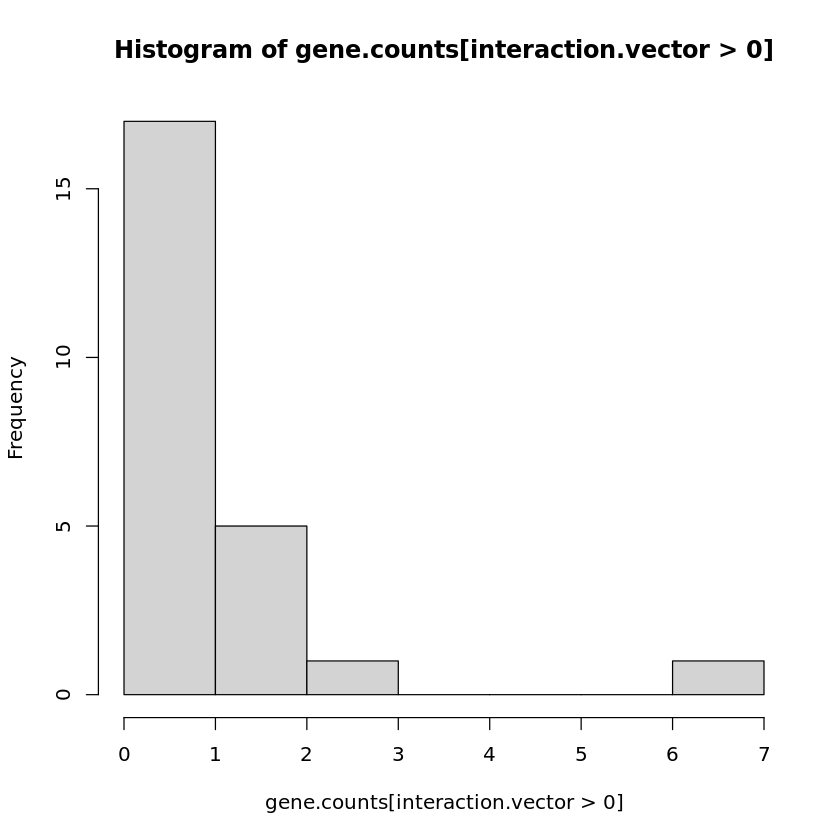

In [53]:
interaction.vector <- enhancer.1.indicator.vector * enhancer.2.indicator.vector
hist(gene.counts[interaction.vector > 0])

In [54]:
gene.counts[interaction.vector > 0]

[1] 1.01 0.01 0.01 1.01 0.01 0.01 6.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
[16] 1.01 0.01 1.01 0.01 1.01 0.01 0.01 2.01 0.01